### Purpose
The goal of this notebook is to predict creditworthiness of borrowers. Previous attempts in the context of the Springboard unit 8.2 miniproject: tree-based algorithms yielded unacceptably high false positive rates. The XGBoost algorithm and the following strategies will be used in an attempt to improve:
1. Sample stratification
2. Weighting/penalizing false positives and false negatives differently
3. Feature trimming
4. Bootstrap aggregation
5. Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from xgboost import XGBClassifier
from scipy.interpolate import griddata

%matplotlib inline
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

<Figure size 432x288 with 0 Axes>

**Variable definitions**

In [2]:
data_file = "./GermanCredit.csv"
rand_seed = 5
num_jobs = 14
search_iterations = 1000
search_scoring_func = make_scorer(average_precision_score)

**Functions**

In [3]:
def make_label_numeric(row):
    if row['Class'] == 'Good':
        return 1
    
    return 0

def print_model_score(model, x_train, y_train, x_test, y_test):
    training_score = average_precision_score(model.predict(x_train), y_train)
    print('Average precision-recall score, training set: {}'.format(np.round(training_score, 2)))

    test_score = average_precision_score(model.predict(x_test), y_test)
    print('Average precision-recall score, test set: {}'.format(np.round(test_score,2)))
    
def display_confusion_matrix(model, class_names, x_test, y_test):
    disp = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    disp.ax_.set_title("Normalized confusion matrix")

#     print("Normalized confusion matrix")
#     print(disp.confusion_matrix)

    plt.show()
    
def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(n_splits=1, random_state=rand_seed)

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    
def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize XGBoost classifier
    xgb_mod = XGBClassifier(**known_params)

    # set up random search
    xgb_random_search = RandomizedSearchCV(
        xgb_mod, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    xgb_best_model = xgb_random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return xgb_best_model, xgb_random_search

In [4]:
# read in raw data
credit_data = pd.read_csv(data_file)

# change credit lable from 'Good' or 'Bad' to 1 or 0
credit_data['Class'] = credit_data.apply(lambda row : make_label_numeric(row), axis=1)

# count number of observations in each class
good_credit_count = len(credit_data[credit_data["Class"] == 1])
bad_credit_count = len(credit_data) - good_credit_count
print('Good credit observations: {}'.format(good_credit_count))
print('Bad credit observations: {}'.format(bad_credit_count))

Good credit observations: 700
Bad credit observations: 300


Data is not balanced. This will be the first issue addressed, but first, let's get a baseline for XGBoot's performance on this dataset by training on the unmanipulated data with all defaults.

**Baseline XGBoost model**

Average precision-recall score, training set: 0.94
Average precision-recall score, test set: 0.82


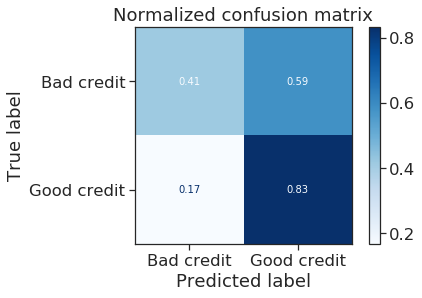

In [5]:
# make training and test data from raw credit data
class_names = np.array(['Bad credit', 'Good credit'])
unbalanced_targets = credit_data['Class']
unbalanced_data = credit_data.drop(['Class'], axis=1)
x_train_unbalanced, x_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(unbalanced_data.values, unbalanced_targets.values, random_state=rand_seed)

# instantiate and train classifier with defaults
xgb_mod = XGBClassifier() 
xgb_mod.fit(x_train_unbalanced, y_train_unbalanced)

# score and show confusion matrix
print_model_score(xgb_mod, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(xgb_mod, class_names, x_test_unbalanced, y_test_unbalanced)

Precision-recall scores look OK. However, we have more false negatives than true negatives! Let's stratify our training and testing samples and then weight the classes to help deal with the fact that our data is not balanced.

**XGBoost model with sample stratification and class weights**

In [6]:
x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified = stratified_train_test_split(unbalanced_data, unbalanced_targets, rand_seed)

Class weight: 0.43

Average precision-recall score, training set: 0.81
Average precision-recall score, test set: 0.72


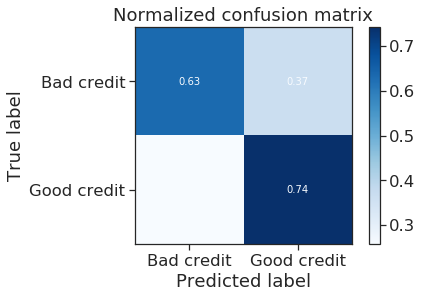

In [7]:
class_weight = bad_credit_count / good_credit_count
print('Class weight: {}\n'.format(np.round(class_weight,2)))

# instantiate and train classifier with class weight
weighted_xgb_mod = XGBClassifier(scale_pos_weight=class_weight) 

# train on stratified data
weighted_xgb_mod.fit(x_train_stratified, y_train_stratified)

# score and show confusion matrix
print_model_score(weighted_xgb_mod, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(weighted_xgb_mod, class_names, x_test_stratified, y_test_stratified)

Nice improvement! The overall precision-recall score went down, and we gave up some true positives, but look at the improvement in false positive rate. Let's run a search on the class weight and see if we can do even better.

**XGBoost with sample stratification and optimized class weight**

In [8]:
known_params = {}

param_dist = {
    'scale_pos_weight': np.arange(0.0, 1.0, 0.001)
}

xbg_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 1 min. for 1000 candidate parameter settings.


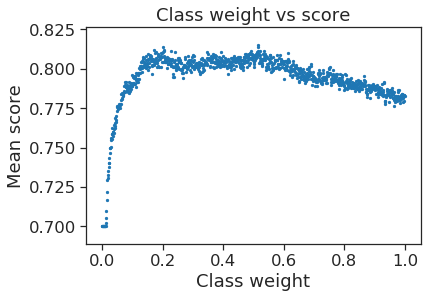

In [9]:
class_weight_grid_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

plt.scatter(class_weight_grid_search_results.param_scale_pos_weight, class_weight_grid_search_results.mean_test_score, s=5)
plt.xlabel("Class weight")
plt.ylabel("Mean score")
plt.title("Class weight vs score")
plt.show()

Average precision-recall score, training set: 0.87
Average precision-recall score, test set: 0.78


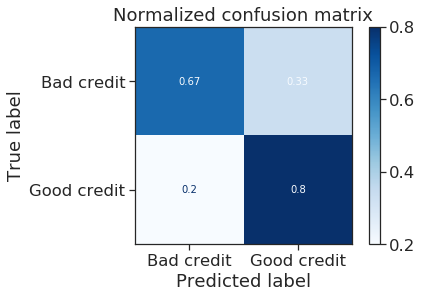

In [10]:
# score the best model and show confusion matrix
print_model_score(xbg_best_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(xbg_best_model, class_names, x_test_stratified, y_test_stratified)

In [11]:
winner = class_weight_grid_search_results[class_weight_grid_search_results['rank_test_score'] == class_weight_grid_search_results['rank_test_score'].min()]
best_class_weight = winner['param_scale_pos_weight'].iloc[0]
print('Winning class weight: {}'.format(best_class_weight))

Winning class weight: 0.514


Nice! Small improvements in training/test scores and true positive/true negative rates. No let's try optimizing some of XGBoost's other hyperparameters.

**XGBoost with stratification, empirical class weight and hyperparameter tuning**

First optimize learning rate and number of estimators:

In [12]:
known_params = {
    'scale_pos_weight': best_class_weight
}

param_dist = {
    'learning_rate': loguniform(0.01, 1.0),
    'n_estimators': range(1,1000)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 5 min. for 1000 candidate parameter settings.


Average precision-recall score, training set: 0.85
Average precision-recall score, test set: 0.75


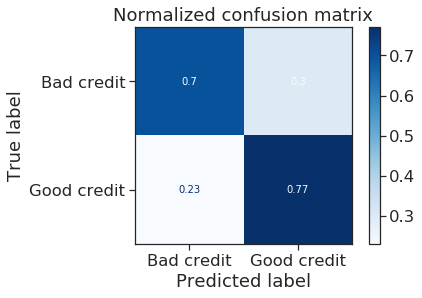

In [13]:
# score the best model and show it's confusion matrix
print_model_score(xgb_best_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(xgb_best_model, class_names, x_test_stratified, y_test_stratified)

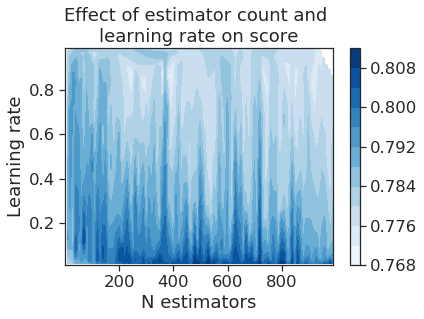

In [14]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, 100)

plt.contourf(xi, yi, zi, 10, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

In [15]:
winner = rand_search_results[rand_search_results['rank_test_score'] == rand_search_results['rank_test_score'].min()]
best_learning_rate = winner['param_learning_rate'].iloc[0]
best_n_estimators = winner['param_n_estimators'].iloc[0]

print('Winning learning rate: {}'.format(np.round(best_learning_rate,2)))
print('Winning estimator count: {}'.format(best_n_estimators))

Winning learning rate: 0.03
Winning estimator count: 348


**Now optimize regularization:**

In [16]:
known_params = {
    'scale_pos_weight': best_class_weight,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators
}

param_dist = {
    'reg_alpha': np.arange(0.0, 10, 0.01),
    'reg_lambda': np.arange(0.0, 10, 0.01)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 3 min. for 1000 candidate parameter settings.


Average precision-recall score, training set: 0.78
Average precision-recall score, test set: 0.71


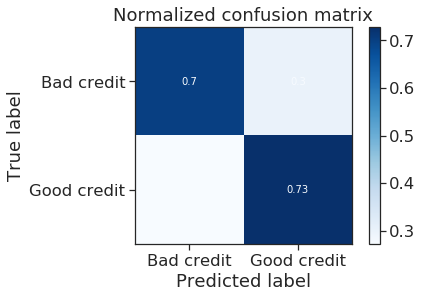

In [17]:
# score the best model and show confusion matrix
print_model_score(xgb_best_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(xgb_best_model, class_names, x_test_stratified, y_test_stratified)

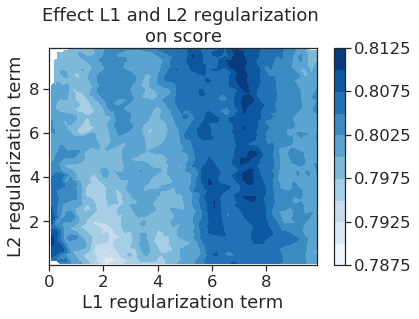

In [18]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

x = rand_search_results['param_reg_alpha']
y = rand_search_results['param_reg_lambda']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, 100)

plt.contourf(xi, yi, zi, 10, cmap=plt.cm.Blues)
plt.xlabel("L1 regularization term")
plt.ylabel("L2 regularization term")
plt.title("Effect L1 and L2 regularization \non score")
plt.colorbar()
plt.show()

In [19]:
winner = rand_search_results[rand_search_results['rank_test_score'] == rand_search_results['rank_test_score'].min()]
best_reg_alpha = winner['param_reg_alpha'].iloc[0]
best_reg_lambda = winner['param_reg_lambda'].iloc[0]

print('Winning L1: {}'.format(np.round(best_reg_alpha,2)))
print('Winning L2: {}'.format(best_reg_lambda))

Winning L1: 6.79
Winning L2: 9.05


**Now optimize depth and gamma:**

In [20]:
known_params = {
    'scale_pos_weight': best_class_weight,
    'learning_rate': best_learning_rate,
    'n_estimators': best_n_estimators,
    'reg_alpha': best_reg_alpha,
    'reg_lambda': best_reg_lambda
}

param_dist = {
    'max_depth': range(0, 20, 1),
    'gamma': np.arange(0.0, 10, 0.01)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 7 min. for 1000 candidate parameter settings.


Average precision-recall score, training set: 0.82
Average precision-recall score, test set: 0.74


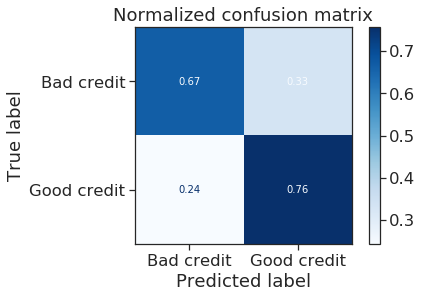

In [21]:
# score the best model and show confusion matrix
print_model_score(xgb_best_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(xgb_best_model, class_names, x_test_stratified, y_test_stratified)

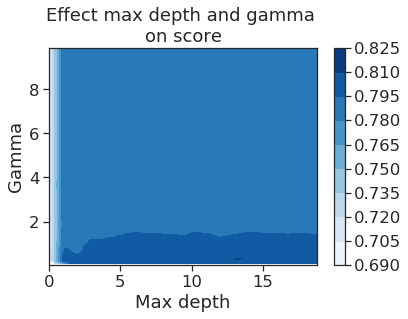

In [22]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

x = rand_search_results['param_max_depth']
y = rand_search_results['param_gamma']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, 100)

plt.contourf(xi, yi, zi, 10, cmap=plt.cm.Blues)
plt.xlabel("Max depth")
plt.ylabel("Gamma")
plt.title("Effect max depth and gamma \non score")
plt.colorbar()
plt.show()

In [23]:
winner = rand_search_results[rand_search_results['rank_test_score'] == rand_search_results['rank_test_score'].min()]
best_max_depth = winner['param_max_depth'].iloc[0]
best_gamma = winner['param_gamma'].iloc[0]

print('Winning max depth: {}'.format(np.round(best_max_depth,2)))
print('Winning gamma: {}'.format(best_gamma))

Winning max depth: 17
Winning gamma: 0.26
